# ***Определение возраста покупателей***

## 1. Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Наше задание - построить модель, которая по фотографии определит приблизительный возраст человека.
Модель должна решать задачу регрессии, при этом предписывается использование метрики качества MAE, значение которой не должно превышать 8.0 на валидационной выборке.

## 2. Описание данных

 Для обучения модели в вашем распоряжении набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`. 
В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками:
 - `file_name`: путь к файлу с фотографией,
 - `real_age`: метка с возрастом человека на фотографии.

## 3. Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    from PIL import Image
except:
    !pip install Pillow
    from PIL import Image

In [3]:
RANDOM_STATE = 666
TABLE_PATH = '/datasets/faces/labels.csv'
IMG_PATH = '/datasets/faces/final_files/'

Загрузим данные с именами файлов изображений и целевыми значениями в датафрейм и исследуем его.

In [4]:
labels = pd.read_csv(TABLE_PATH)
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


На первый взгляд данные в файле labels.csv соответствуют описанию. У нас есть 7591 строк с именами файлов изображений и целочисленными целевыми значениями. Пропусков в таблице нет.

Посмотрим нет ли повторяющихся имен файлов.

In [5]:
if len(labels['file_name'].unique()) == len(labels):
    print('Повторений нет.')
else:
    print('Есть повторения.')

Повторений нет.


Итак, в выборке 7591 образец. Посмотрим на распределение возраста в выборке.

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


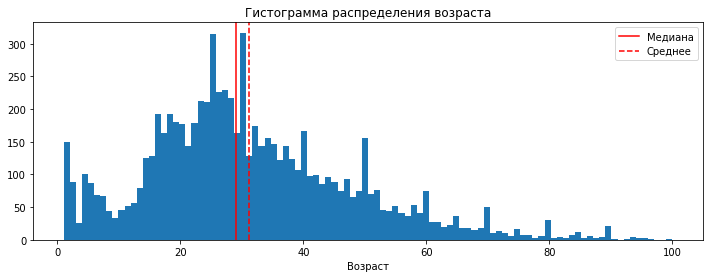

In [6]:
print(labels['real_age'].describe())

fig, ax = plt.subplots(figsize=(12, 4));
plt.hist(labels['real_age'], bins=100);
plt.axvline(x=labels['real_age'].median(), color='red', label='Медиана');
plt.axvline(x=labels['real_age'].mean(), color='red', label='Среднее', linestyle='--');
plt.legend()
plt.title(f'Гистограмма распределения возраста')
plt.xlabel('Возраст')
plt.show();

В датасете фотографии людей возрастом от 1 года до 100 лет, средний возраст - 31 год. Распределение не является нормальным, смещено влево. Большинство изображений в датасете относятся к людям в возрасте до 60-ти лет.

Выведем подвыборку из 16 изображений.

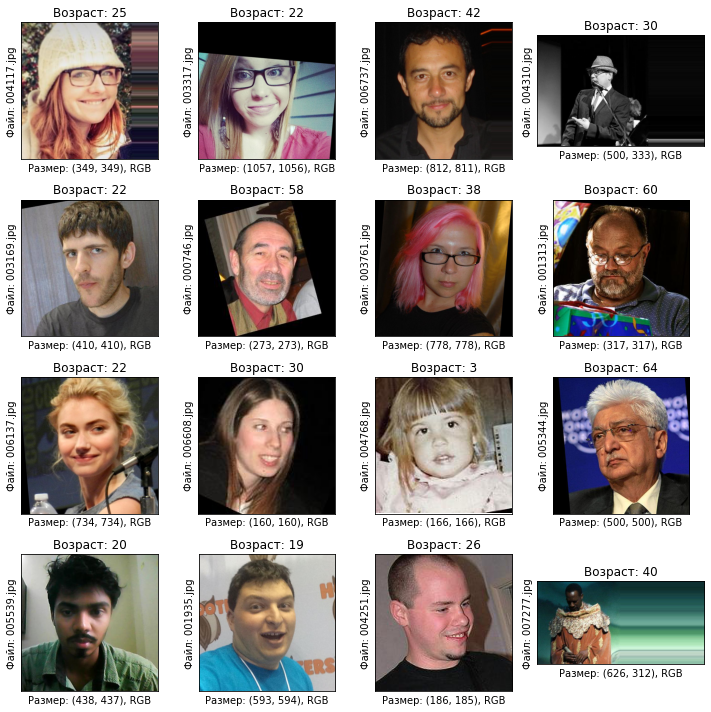

In [7]:
imgs = labels.sample(n=16, random_state=RANDOM_STATE).reset_index(drop=True)
fig = plt.figure(figsize=(10,10))
for i, img in enumerate(imgs['file_name']):
    image = Image.open(IMG_PATH + img)
    fig.add_subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(f'Возраст: {imgs["real_age"][i]}')
    plt.xlabel(f'Размер: {image.size}, {image.mode}')
    plt.ylabel(f'Файл: {img}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете содержатся фотографии людей разного возраста, пола, расы, сделанные с разных ракурсов и расстояния. Изображения разного размера и качества. Большинство изображений - портретного характера. Похоже, датасет подойдет для поставленной задачи, но потребуется применить аугментации, чтобы приблизить изображения к тем, которые можно получить в прикассовой зоне магазина, сделать обучени более устойчивым и уменьшить эффект переобучения на тренировочной выборке.

Ознакомившись с тренировочным датасетом и с учетом поставленной задачи, можно сделать вывод о целесообразности применения следующих аугментаций обучающих данных:  
 - Вращение на небольшой угол. Изображения людей на кассе будут различаться по наклону в разные стороны, в датасете многие изображения также имеют наклон.
 - Сдвиг на небольшой угол. Это будет примерно соответствовать искажениям перспективы.
 - Отражение по горизонтали. С учетом симметрии человеческого лица внесет дополнительное реалистичное разнообразие в обучающую выборку.
 - Зум. Люди на кассе будут находится на разной дистанции от камеры. В обучающей выборке - изображения людей, находящихся на разном удалении.
 - Смещение. Фото людей в датасете не всегда центрированы. Люди на кассе магазина не всегда будут находиться прямо перед камерой.
 - Изменения яркости изображений будут соответствовать разному уровню освещенности в реальных условиях и разному уровню яркости изображений в датасете.

## 4. Обучение модели

Для решения поставленной задачи будем использовать backbone предобученной сети ResNet50. В качестве головы добавим слой `GlobalAveragePooling2D` для уменьшения размерности и два полносвязных слоя на 1000 и на 1 выходной нейрон с активациями `ReLU`. Будем использовать батчи размером 32 и приведем входные изображения к размеру 224х224, что соответствует параметрам обучения backbone ResNet50. Применим оптимизатор Adam и MSE в качестве лосс-функции. Для ускорения обучения используем прерывания. 

Модель будем обучать на облачном сервере с GPU. Код загрузки данных, создания и обучения модели и вывод результата на экран:

```python

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import Callback, ReduceLROnPlateau
import numpy as np
import pandas as pd

RANDOM_STATE = 666

# Создание прерывания при достижении определенного значения (threshold=8.) метрики на валидации
class EarlyStoppingAtThreshold(Callback):
    def __init__(self, monitor='val_mean_absolute_error', threshold=8., mode='min'):
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.mode = mode
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Metric '{self.monitor}' not found in logs.")

        # Проверка, достигла ли метрика значения threshold
        if (self.mode == 'min' and current <= self.threshold) or \
           (self.mode == 'max' and current >= self.threshold):
            print(f"\nStopping training: {self.monitor} reached {current:.4f} (threshold={self.threshold})")
            self.model.stop_training = True
            self.stopped_epoch = epoch + 1

def load_train(path):
    # Загрузчик тренировочной выборки
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        rotation_range=20,
        horizontal_flip=True,
        zoom_range=[0.5, 1.1],
        shear_range=0.1,
        brightness_range=[0.5, 1.5],
        width_shift_range=0.2,
        height_shift_range=0.2,
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        pd.read_csv(path + '/labels.csv', dtype={'real_age': 'float32'}),
        path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        color_mode='rgb',
        subset='training',
        seed=RANDOM_STATE
    )

    return train_datagen_flow

def load_test(path):

# Загрузчик валидационной выборки
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
    )

    validation_datagen_flow = validation_datagen.flow_from_dataframe(
        pd.read_csv(path + '/labels.csv', dtype={'real_age': 'float32'}),
        path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        color_mode='rgb',
        subset='validation',
        seed=RANDOM_STATE
    )

    return validation_datagen_flow

# Создание модели
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1000, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error']) 
    
    return model

# Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=60,
               steps_per_epoch=None, validation_steps=None):


    # Инициализация прерывания с условием val_mae ≤ 0.5
    early_stop = EarlyStoppingAtThreshold(
        monitor='val_mean_absolute_error', 
        threshold=8., 
        mode='min'
    )
    # Инициализация прерывания с уменьшением скорости обучения
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.0001)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True,
              callbacks=[early_stop, reduce_lr]
              )

    return model

```

```
2025-03-25 17:34:05.806584: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-03-25 17:34:05.808576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-03-25 17:34:06.895108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-25 17:34:06.906873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-03-25 17:34:06.906951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-25 17:34:06.906991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-25 17:34:06.909076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-03-25 17:34:06.909433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-03-25 17:34:06.911988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-03-25 17:34:06.913278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-03-25 17:34:06.913338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-03-25 17:34:06.917239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-03-25 17:34:07.124408: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-03-25 17:34:07.132517: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2025-03-25 17:34:07.133762: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x40b6fb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-25 17:34:07.133792: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-25 17:34:07.292541: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53ae460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-25 17:34:07.292594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-03-25 17:34:07.295034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-03-25 17:34:07.295103: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-25 17:34:07.295143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-25 17:34:07.295185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-03-25 17:34:07.295216: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-03-25 17:34:07.295262: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-03-25 17:34:07.295289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-03-25 17:34:07.295310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-03-25 17:34:07.299677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-03-25 17:34:07.299765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-25 17:34:07.676700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-03-25 17:34:07.676754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-03-25 17:34:07.676788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-03-25 17:34:07.680881: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-25 17:34:07.680946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'keras.engine.sequential.Sequential'>
Epoch 1/60
2025-03-25 17:35:07.851143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-25 17:35:08.243487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
 - 151s - loss: 570.3583 - mean_absolute_error: 18.7411 - val_loss: 591.9317 - val_mean_absolute_error: 26.0515
Epoch 2/60
 - 126s - loss: 373.1155 - mean_absolute_error: 14.7885 - val_loss: 145.1388 - val_mean_absolute_error: 13.3765
Epoch 3/60
 - 126s - loss: 284.9536 - mean_absolute_error: 12.7567 - val_loss: 220.6443 - val_mean_absolute_error: 12.7357
Epoch 4/60
 - 128s - loss: 268.6744 - mean_absolute_error: 12.4359 - val_loss: 280.3608 - val_mean_absolute_error: 13.8063
Epoch 5/60
 - 120s - loss: 247.6869 - mean_absolute_error: 11.8574 - val_loss: 155.4750 - val_mean_absolute_error: 11.5944
Epoch 6/60
 - 123s - loss: 226.9373 - mean_absolute_error: 11.3871 - val_loss: 483.3544 - val_mean_absolute_error: 17.1889
Epoch 7/60
 - 126s - loss: 275.6224 - mean_absolute_error: 12.5958 - val_loss: 517.4268 - val_mean_absolute_error: 13.0478
Epoch 8/60
 - 127s - loss: 331.9984 - mean_absolute_error: 13.9067 - val_loss: 426.1157 - val_mean_absolute_error: 13.3658
Epoch 9/60
 - 119s - loss: 309.0126 - mean_absolute_error: 13.4261 - val_loss: 396.3353 - val_mean_absolute_error: 15.8337
Epoch 10/60
 - 123s - loss: 282.4979 - mean_absolute_error: 12.8676 - val_loss: 235.1257 - val_mean_absolute_error: 13.4554
Epoch 11/60
 - 123s - loss: 255.2102 - mean_absolute_error: 12.2635 - val_loss: 446.6508 - val_mean_absolute_error: 13.0505
Epoch 12/60
 - 121s - loss: 247.8615 - mean_absolute_error: 12.1666 - val_loss: 67.4855 - val_mean_absolute_error: 12.0067
Epoch 13/60
 - 124s - loss: 235.0664 - mean_absolute_error: 11.8771 - val_loss: 241.8345 - val_mean_absolute_error: 12.3476
Epoch 14/60
 - 124s - loss: 221.8611 - mean_absolute_error: 11.4815 - val_loss: 383.9892 - val_mean_absolute_error: 14.4338
Epoch 15/60
 - 125s - loss: 217.9264 - mean_absolute_error: 11.4687 - val_loss: 298.8101 - val_mean_absolute_error: 15.2921
Epoch 16/60
 - 124s - loss: 212.1638 - mean_absolute_error: 11.2882 - val_loss: 288.8181 - val_mean_absolute_error: 10.5202
Epoch 17/60
 - 125s - loss: 205.2429 - mean_absolute_error: 11.0295 - val_loss: 268.7834 - val_mean_absolute_error: 11.4931
Epoch 18/60
 - 122s - loss: 200.2497 - mean_absolute_error: 10.9173 - val_loss: 67.6581 - val_mean_absolute_error: 10.1022
Epoch 19/60
 - 123s - loss: 188.7853 - mean_absolute_error: 10.5902 - val_loss: 232.3911 - val_mean_absolute_error: 12.2208
Epoch 20/60
 - 125s - loss: 186.5500 - mean_absolute_error: 10.5211 - val_loss: 158.4203 - val_mean_absolute_error: 9.8155
Epoch 21/60
 - 120s - loss: 177.5521 - mean_absolute_error: 10.2373 - val_loss: 97.3172 - val_mean_absolute_error: 9.5664
Epoch 22/60
 - 115s - loss: 175.0016 - mean_absolute_error: 10.2524 - val_loss: 226.0108 - val_mean_absolute_error: 9.5096
Epoch 23/60
 - 119s - loss: 165.8533 - mean_absolute_error: 9.8506 - val_loss: 104.0536 - val_mean_absolute_error: 8.9617
Epoch 24/60
 - 123s - loss: 161.5225 - mean_absolute_error: 9.7114 - val_loss: 258.2045 - val_mean_absolute_error: 9.8353
Epoch 25/60
 - 123s - loss: 158.5311 - mean_absolute_error: 9.6674 - val_loss: 201.0163 - val_mean_absolute_error: 8.9134
Epoch 26/60
 - 115s - loss: 151.6452 - mean_absolute_error: 9.4492 - val_loss: 36.6922 - val_mean_absolute_error: 8.6506
Epoch 27/60
 - 120s - loss: 152.9490 - mean_absolute_error: 9.4235 - val_loss: 162.4293 - val_mean_absolute_error: 9.7794
Epoch 28/60
 - 122s - loss: 148.3516 - mean_absolute_error: 9.2450 - val_loss: 59.0860 - val_mean_absolute_error: 8.4933
Epoch 29/60
 - 123s - loss: 141.2436 - mean_absolute_error: 9.0353 - val_loss: 58.5618 - val_mean_absolute_error: 8.3578
Epoch 30/60
 - 123s - loss: 139.8517 - mean_absolute_error: 9.0724 - val_loss: 139.4789 - val_mean_absolute_error: 8.6326
Epoch 31/60
 - 117s - loss: 135.8770 - mean_absolute_error: 8.9036 - val_loss: 169.6943 - val_mean_absolute_error: 9.2262
Epoch 32/60
 - 115s - loss: 134.6222 - mean_absolute_error: 8.8156 - val_loss: 79.7591 - val_mean_absolute_error: 8.0923
Epoch 33/60
 - 116s - loss: 130.6035 - mean_absolute_error: 8.6913 - val_loss: 146.8944 - val_mean_absolute_error: 9.6855
Epoch 34/60
 - 117s - loss: 127.4106 - mean_absolute_error: 8.5294 - val_loss: 84.9786 - val_mean_absolute_error: 8.0380
Epoch 35/60
 - 126s - loss: 122.5758 - mean_absolute_error: 8.4758 - val_loss: 47.5545 - val_mean_absolute_error: 8.4895
Epoch 36/60
 - 123s - loss: 120.1286 - mean_absolute_error: 8.3848 - val_loss: 305.2185 - val_mean_absolute_error: 8.3180
Epoch 37/60
 - 115s - loss: 119.1683 - mean_absolute_error: 8.2851 - val_loss: 51.3930 - val_mean_absolute_error: 8.3452
Epoch 38/60
 - 116s - loss: 119.5150 - mean_absolute_error: 8.3126 - val_loss: 139.4986 - val_mean_absolute_error: 7.8384

Stopping training: val_mean_absolute_error reached 7.8384 (threshold=8.0)
Test MAE: 7.8384

```

Модель завершила обучение на 38-й эпохе по достижении значения метрики 7.8384 на валидационной выборке (меньше минимального значения 8, заданного заказчиком).

## Анализ обученной модели

Модель быстро достигла неоходимых значений метрики на валидационной выборке. Loss и метрика на обучающих данных устойчиво снижались на всем обучении. На валидационной выборке loss и метрика также снижались на всем периоде обучения, хотя и менее устойчиво. Модель не переобучилась на тренировочных данных и может достичь лучших результатов при увеличении количества эпох обучения. Неустойчивость в показателях на валидации также можно смягчить, уменьшив скорость обучения и, возможно, увеличив размер батча, но это увеличит время обучения, которое в данный момент ограничено.
Таким образом, модель удовлетворяет условиям ТЗ, обучена на данных близких к реальным и готова к тестированию в реальных условиях.